# 1. Imports

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '10'

In [2]:
from pathlib import Path
from tqdm import tqdm

import numpy as np

# Plotting
import cmocean
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
color_map = cmocean.cm.ice
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Methods
import pynpoint as pp
from pynpoint.core.dataio import OutputPort, InputPort
from pynpoint.readwrite.hdf5reading import Hdf5ReadingModule
from pynpoint.processing.stacksubset import StackAndSubsetModule

from s4hci.utils.pca import pca_psf_subtraction_gpu
from s4hci.utils.data_handling import save_as_fits
from s4hci.utils.data_handling import read_s4hci_root_dir

# Evaluation
from applefy.detections.uncertainty import compute_detection_uncertainty
from applefy.utils.photometry import AperturePhotometryMode
from applefy.statistics import TTest, fpf_2_gaussian_sigma, gaussian_sigma_2_fpf

# 2. All directories needed

In [3]:
root_dir = Path(read_s4hci_root_dir())

Data in the S4HCI_ROOT_DIR found. Location: /fast/mbonse/s4


In [4]:
experiment_root_dir = root_dir / Path("70_results/x2_af_lep/MCMC/")

In [5]:
fwhm = 3.6

# 3. Estimate the Photometry and astrometry with PynPoint

## 3.1 Create the PynPoint database

In [6]:
pipeline = pp.Pypeline(
    working_place_in=str(experiment_root_dir),
    input_place_in=str(experiment_root_dir),
    output_place_in=str(experiment_root_dir))

PynPoint v0.11.0

Working place: /fast/mbonse/s4/70_results/x2_af_lep/MCMC
Input place: /fast/mbonse/s4/70_results/x2_af_lep/MCMC
Output place: /fast/mbonse/s4/70_results/x2_af_lep/MCMC

Database: /fast/mbonse/s4/70_results/x2_af_lep/MCMC/PynPoint_database.hdf5
Configuration: /fast/mbonse/s4/70_results/x2_af_lep/MCMC/PynPoint_config.ini

Number of CPUs: 20
Number of threads: 10


## 3.2 Read in the HDF5 file

In [6]:
read_data_module = Hdf5ReadingModule(
    name_in="01_read_data",
    input_filename="HD35850_294_088_C-0085_A_.hdf5",
    input_dir=str(root_dir / Path("30_data")),
    tag_dictionary={"object_selected" : "object_selected",
                    "psf_selected" : "psf_selected"})

In [7]:
pipeline.add_module(read_data_module)

In [8]:
pipeline.run_module("01_read_data")


-----------------
Hdf5ReadingModule
-----------------

Module name: 01_read_data
Reading HDF5 file... [DONE]                      
Output ports: object_selected (13809, 165, 165), psf_selected (1526, 23, 23)


## 3.3 Cut and stack the science data for faster PCA iterations

In [9]:
science_data = pipeline.get_data("object_selected")
angles = pipeline.get_attribute("object_selected", "PARANG", static=False)

print(science_data.shape)
print(angles.shape)

(13809, 165, 165)
(13809,)


In [10]:
science_data_cut = science_data[:, 25:-25, 25:-25]

In [11]:
binning = 5  # stack every 5 frames
angles_stacked = np.array([
    np.mean(i) 
    for i in np.array_split(angles, int(len(angles) / binning))])
science_stacked = np.array([
    np.mean(i, axis=0) 
    for i in np.array_split(science_data_cut, int(len(angles) / binning))])

In [12]:
obj_port = OutputPort(
    "01_science_prep",
    pipeline.m_data_storage)
obj_port.set_all(science_stacked)

In [13]:
input_port = InputPort(
    "object_selected",
    pipeline.m_data_storage)
obj_port.copy_attributes(input_port)

In [14]:
pipeline.set_attribute("01_science_prep", "PARANG", angles_stacked, False)

## 3.4 Find the best number of PCA components

In [7]:
science_data_prep = pipeline.get_data("01_science_prep")
angles_prep = pipeline.get_attribute("01_science_prep", "PARANG", static=False)
angles_prep = np.deg2rad(angles_prep)

In [8]:
print(science_data_prep.shape)
print(angles_prep.shape)

(2761, 115, 115)
(2761,)


In [9]:
num_components = np.arange(5, 200, 10)

In [10]:
pca_residuals = pca_psf_subtraction_gpu(
    images=science_data_prep,
    angles=angles_prep,
    pca_numbers=num_components,
    device="cpu",
    approx_svd=2000,
    verbose = True)

Compute PCA basis ...[DONE]
Compute PCA residuals ...

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.32it/s]

[DONE]


In [11]:
init_planet_position  = np.array((68.55, 54.78)) # Result from previous mcmc
# Use pixel values spaced by the FWHM
photometry_mode_planet = AperturePhotometryMode("AS", search_area=0.5, psf_fwhm_radius=fwhm/2)
photometry_mode_noise = AperturePhotometryMode("AS", psf_fwhm_radius=fwhm/2)

In [12]:
all_snr_pca = []
for i in tqdm(range(len(num_components))):
    _, _, snr_mean = compute_detection_uncertainty(
        frame=pca_residuals[i],
        planet_position=init_planet_position, 
        statistical_test=TTest(),
        psf_fwhm_radius=fwhm,
        photometry_mode_planet=photometry_mode_planet,
        photometry_mode_noise=photometry_mode_noise,
        safety_margin=1.,
        num_rot_iter=50)
    
    all_snr_pca.append(np.round(np.mean(snr_mean), 1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.85it/s]


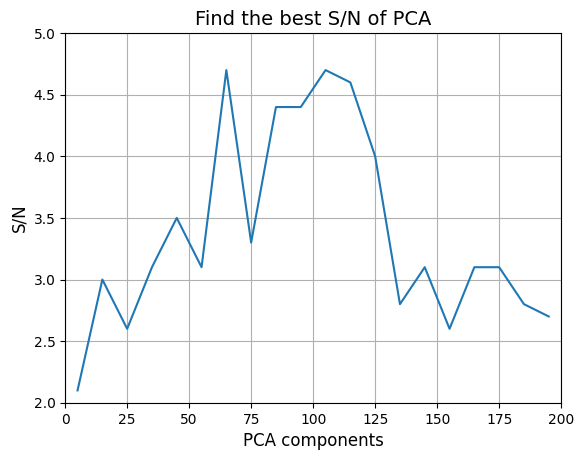

In [13]:
plt.plot(num_components, all_snr_pca)
plt.ylabel("S/N", fontsize=12)
plt.xlabel("PCA components", fontsize=12)
plt.title("Find the best S/N of PCA", fontsize=14)

plt.xlim(0, 200)
plt.ylim(2, 5)
plt.grid()

In [14]:
best_num_pca = num_components[np.argmax(all_snr_pca)]
print("The best number of components is: " + str(best_num_pca))
print("The peak S/N is : " + str(np.max(all_snr_pca)))

The best number of components is: 65
The peak S/N is : 4.7


Text(0.5, 1.01, 'Optimal PCA (65 components)')

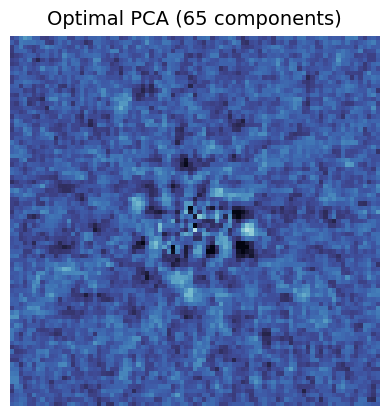

In [15]:
pca_residual_frame = pca_residuals[np.argmax(all_snr_pca)]
median= np.median(pca_residual_frame)
scale = np.max(np.abs(pca_residual_frame))
zoom = 15

plt.imshow(
    pca_residual_frame[zoom:-zoom, zoom:-zoom],
    cmap=color_map,
    vmin=median - scale*0.5, vmax=median + scale*0.8,
    origin="lower")
plt.axis("off")
plt.title("Optimal PCA (65 components)", fontsize=14,y=1.01)

## 3.5 Create a Master Template for the PSF

In [24]:
psf_frames = pipeline.get_data("psf_selected")

In [25]:
psf_template = np.median(psf_frames, axis=0)

(-0.5, 114.5, 114.5, -0.5)

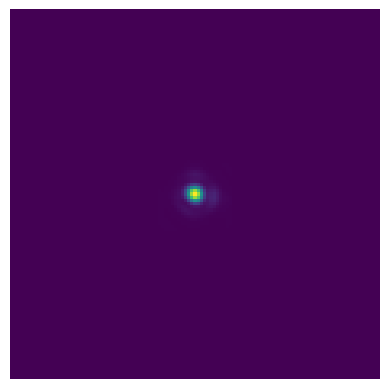

In [26]:
# pad the psf template
padded_psf = np.pad(psf_template, 
                  pad_width=((46, 46), (46, 46)), 
                  mode='constant', 
                  constant_values=0)

plt.imshow(padded_psf)
plt.axis("off")

In [27]:
psf_port = OutputPort("01_psf_padded",
                      pipeline.m_data_storage)
psf_port.set_all(np.expand_dims(padded_psf, axis=0))

## 3.6 Simplex minimization, used as initialization for MCMC

In [28]:
simplex_module = pp.SimplexMinimizationModule(
    name_in='03_simplex', 
    image_in_tag='01_science_prep', 
    psf_in_tag='01_psf_padded', 
    res_out_tag='03_simplex_residual', 
    flux_position_tag='03_simplex_result',
    position=(init_planet_position[0], init_planet_position[1]), 
    magnitude=9.5, 
    psf_scaling=-1/0.0179,  # The data is taken with an ND filter
    merit='hessian', 
    tolerance=0.1, 
    pca_number=int(best_num_pca), 
    residuals='mean', 
    offset=2) 

In [29]:
pipeline.add_module(simplex_module) 
pipeline.run_module('03_simplex')


-------------------------
SimplexMinimizationModule
-------------------------

Module name: 03_simplex
Input ports: 01_science_prep (2761, 115, 115), 01_psf_padded (1, 115, 115)
Input parameters:
   - Number of principal components = [65]
   - Figure of merit = hessian
   - Residuals type = mean
   - Absolute tolerance (pixels/mag) = 0.1
   - Maximum offset = 2
   - Guessed position (x, y) = (68.55, 54.78)
   - Aperture position (x, y) = (69, 55)
   - Aperture radius (pixels) = 3
Image center (y, x) = (57.0, 57.0)
Simplex minimization... 65 PC - chi^2 = 1.52e+01 [DONE]
Best-fit parameters:
   - Position (x, y) = (68.78, 54.75)
   - Separation (mas) = 323.70
   - Position angle (deg) = 259.19
   - Contrast (mag) = 9.98
Output ports: 03_simplex_residual (41, 115, 115), 03_simplex_result (41, 6)


In [16]:
simplex_results = pipeline.get_data('03_simplex_result')

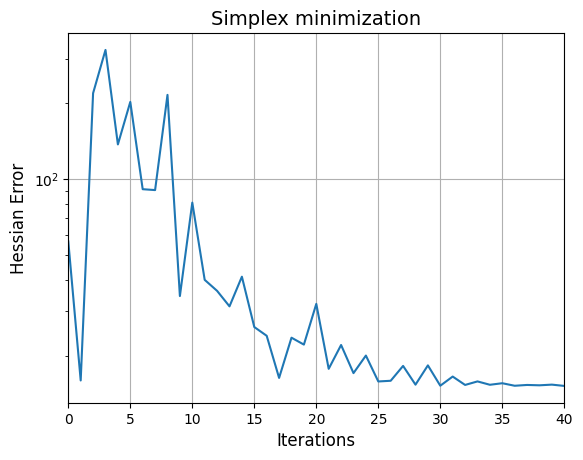

In [17]:
# Simplex Error
plt.plot(simplex_results[:, -1])
plt.yscale("log")
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Hessian Error", fontsize=12)
plt.title("Simplex minimization", fontsize=14)
plt.xlim(0, 40)
plt.grid()

In [18]:
best_idx = np.argmin(simplex_results[:, -1])
best_idx

40

In [19]:
simplex_best_result = simplex_results[best_idx, :]
simplex_best_result

array([ 68.77608758,  54.75116433,   0.32370005, 259.18860748,
         9.98117147,  15.16769487])

In [20]:
residual_no_planet = pipeline.get_data('03_simplex_residual')[best_idx]

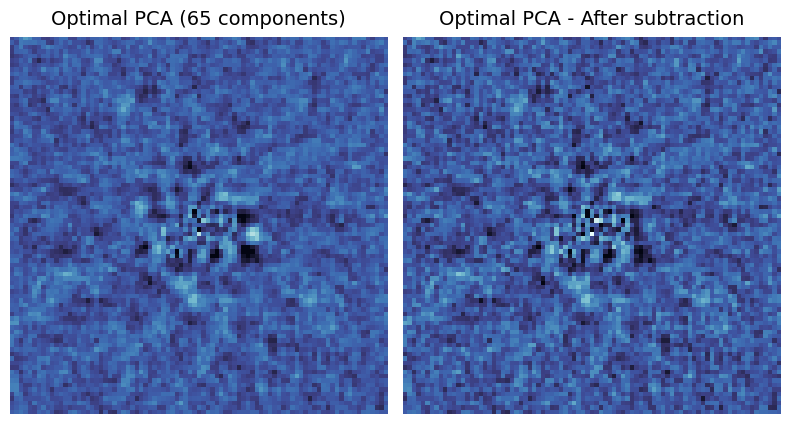

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

# Plot the original residual
median= np.median(pca_residual_frame)
scale = np.max(np.abs(pca_residual_frame))
zoom = 15

ax1.imshow(
    pca_residual_frame[zoom:-zoom, zoom:-zoom],
    cmap=color_map,
    vmin=median - scale*0.5, vmax=median + scale*0.8,
    origin="lower")

ax1.axis("off")
ax1.set_title("Optimal PCA (65 components)", fontsize=14,y=1.01)

# Plot the residual without the planet
ax2.imshow(
    residual_no_planet[zoom:-zoom, zoom:-zoom],
    cmap=color_map,
    vmin=median - scale*0.5, vmax=median + scale*0.8,
    origin="lower")

ax2.axis("off")
ax2.set_title("Optimal PCA - After subtraction", fontsize=14,y=1.01)

plt.tight_layout()

## 3.7 Run MCMC to get an estimate of the Error

In [22]:
# Bounds for the MCMC 
# Separations +- 100 mas
# Angle +- 10 deg
# Contrast +- 1 mag

dsep, dphi, dcontrast = 0.1, 10, 1.0

mcmc_module = pp.MCMCsamplingModule(
    name_in='04_MCMC_planet', 
    image_in_tag='01_science_prep', 
    psf_in_tag='01_psf_padded', 
    chain_out_tag='04_MCMC_chain', 
    param=tuple(simplex_best_result[2:5]), 
    bounds=((simplex_best_result[2]-dsep, simplex_best_result[2]+dsep),
            (simplex_best_result[3]-dphi, simplex_best_result[3]+dphi),
            (simplex_best_result[4]-dcontrast, simplex_best_result[4]+dcontrast)), 
    nwalkers=50,
    nsteps=200,
    psf_scaling=-1/0.0179, # ND filter
    pca_number=int(best_num_pca), 
    mask=None, 
    extra_rot=0.0, 
    merit='hessian', 
    residuals='mean', 
    resume=False)

In [ ]:
pipeline.add_module(mcmc_module)
pipeline.run_module('04_MCMC_planet')


------------------
MCMCsamplingModule
------------------

Module name: 04_MCMC_planet
Input ports: 01_science_prep (2761, 115, 115), 01_psf_padded (1, 115, 115)
Input parameters:
   - Number of principal components: 65
   - Figure of merit: hessian
   - Aperture position (x, y): (69, 55)
   - Aperture radius (pixels): 3
Hessian standard deviation: 8.76e-02
Reset backend of emcee... [DONE]
Sampling the posterior distributions with MCMC...


  4%|█████▊                                                                                                                                                               | 7/200 [10:44<4:54:46, 91.64s/it]

## 3.8 Plot the result

In [71]:
mcmc_results = pipeline.get_data('04_MCMC_chain')

In [85]:
mcmc_mean = np.median(mcmc_results[-1:,:, :], axis=0)


mcmc_sigma = np.std(mcmc_results[-1,:, :], axis=0)

In [86]:
mcmc_mean

array([[  0.32382887, 259.18440775,   9.97735706],
       [  0.32397759, 259.13672948,   9.95582177],
       [  0.32398811, 259.1750059 ,   9.98762161],
       [  0.32378003, 259.20124072,   9.97266189],
       [  0.32363003, 259.1839558 ,   9.97233878],
       [  0.32358091, 259.19015944,   9.98774498],
       [  0.32358615, 259.19609243,   9.98619624],
       [  0.32366719, 259.19974482,   9.97959369],
       [  0.32368606, 259.19228272,   9.98803894],
       [  0.32378371, 259.20844586,   9.98191604],
       [  0.32357686, 259.187886  ,   9.98535459],
       [  0.32378428, 259.18024877,   9.97552839],
       [  0.32374198, 259.18237669,   9.97745616],
       [  0.3236615 , 259.15910483,   9.95721203],
       [  0.32368497, 259.18926562,   9.9825182 ],
       [  0.32371789, 259.20724063,   9.97111307],
       [  0.32359026, 259.20793103,   9.9966166 ],
       [  0.32349767, 259.18868773,   9.96754288],
       [  0.32356045, 259.17818827,  10.0052319 ],
       [  0.32365155, 259.19504

(array([2., 0., 1., 5., 3., 3., 4., 0., 1., 1.]),
 array([ 9.95582177,  9.96076279,  9.9657038 ,  9.97064481,  9.97558582,
         9.98052684,  9.98546785,  9.99040886,  9.99534987, 10.00029089,
        10.0052319 ]),
 <BarContainer object of 10 artists>)

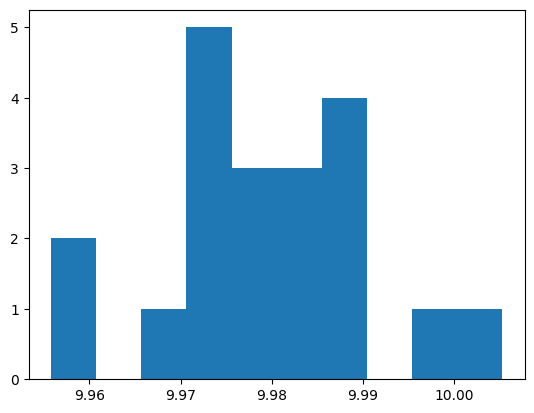

In [87]:
plt.hist(mcmc_results[-1,:, 2])

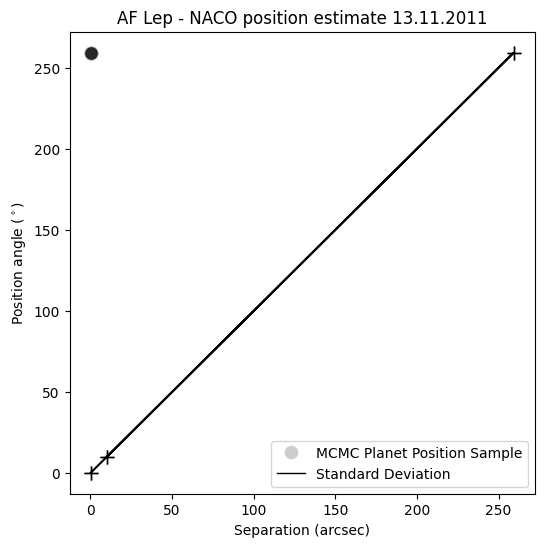

In [88]:
x = mcmc_results[-1, :, 0]
y = mcmc_results[-1, :, 1]

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    x=x,
    y=y, 
    s=100, 
    color=".15", 
    alpha=0.2, 
    label='MCMC planet position sample')

ax.errorbar(
    x=mcmc_mean[0],
    xerr=mcmc_sigma[0],
    y=mcmc_mean[1],
    yerr=mcmc_sigma[1],
    c='k',
    capsize=5)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='MCMC Planet Position Sample',
                          markerfacecolor='k', markersize=10, alpha=0.2),
                   Line2D([0], [0], color='k', lw=1, label='Standard Deviation')]

ax.legend(handles=legend_elements, loc='best')

ax.ticklabel_format(useOffset=False)
ax.set_xlabel('Separation (arcsec)')
ax.set_ylabel(r'Position angle ($^\circ$)')
ax.set_title('AF Lep - NACO position estimate 13.11.2011')
#f.savefig('AF_Lep_NACO_position_estimate.pdf', bbox_inches='tight')
plt.show()